<h1> Imports

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFdr
from scipy.signal import butter, lfilter, filtfilt, freqz
from scipy import signal
import pywt

<h1> Fitlering Functions

In [2]:
def apply_butterband_filter(input_df):
    df = input_df.copy()
    for col in df.columns:
        df[col] = filter_df_col(df, col)
        
    return df

def filter_df_col(df, col):
    fs = 512.0
    lowcut = 12.0
    highcut = 25.0
    
    vals = df[col].values
    return butter_bandpass_filter(vals, lowcut, highcut, fs)

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = data * 50    # amplify data
    y = filtfilt(b, a, data)
    return y

In [168]:
def wavelet_dwt(df):
    return pywt.dwt(df.values, 'db5')

def pca_and_inverse(df):
    pca = PCA(0.90).fit(df)
    components = pca.transform(df)
    return pca.inverse_transform(components)
    
def pca_feature_selection(df):
    pca = PCA(1).fit(df)
    return pca.transform(df)

In [169]:
record_export_folder = 'recordings'
# keep_cols = ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8'] # ['Timestamp', 'EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']
keep_cols = ['P7', 'O1', 'O2', 'P8'] # ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8'] # ['Timestamp', 'EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']

def load_df(file_name):
    file_path = os.path.join(record_export_folder, file_name)
    return pd.read_csv(file_path, skiprows=0, header=0)

def trim_cols(df):
    return df[keep_cols]

def filter_data(df):
#     df = apply_butterband_filter(df)
    return wavelet_dwt(df)

<h1> Data from 4 Sensors

In [170]:
df = trim_cols(load_df('checkerboard_recording_sultan_{}.csv'.format(1)))
approx, decomp = filter_data(df)
decomp = np.asarray(decomp)

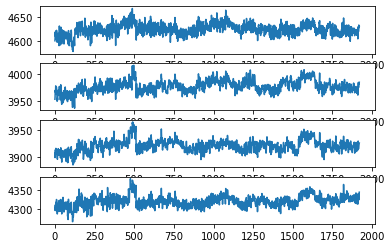

In [171]:
subplot = 0
fig, axs = plt.subplots(4)
for col in df.columns:
    axs[subplot].plot(df[col].values)
    subplot += 1

<h1> Wavlet Decomposition 

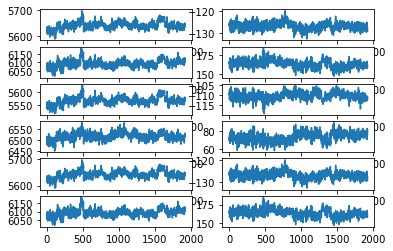

In [172]:
bands = approx.shape[1]
subplot = 0
axis = 0
fig, axs = plt.subplots(bands, 2)
for dataset in [approx, decomp]:
    for col in range(bands):
        axs[subplot, axis].plot(dataset[:,col])
        subplot += 1
    subplot = 0
    axis += 1

<h1> PCA Seperating Approx and Discrete

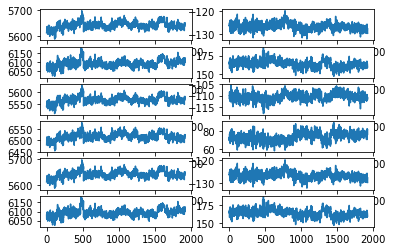

In [173]:
bands = approx.shape[1]
subplot = 0
axis = 0
pca_approx = pca_and_inverse(approx) 
pca_decomp = pca_and_inverse(decomp)
fig, axs = plt.subplots(bands, 2)
for dataset in [pca_approx, pca_decomp]:
    for col in range(bands):
        axs[subplot, axis].plot(dataset[:,col])
        subplot += 1
    subplot = 0
    axis += 1

<h1> PCA

In [174]:
subplot = 0
axis = 0
full = np.concatenate((approx, decomp), axis=1)
pca_full = pca_and_inverse(full)
bands = pca_full.shape[1]

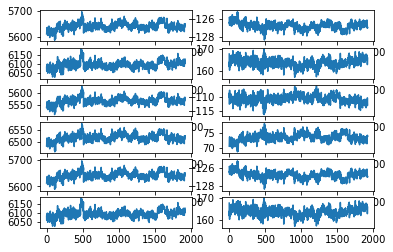

In [175]:
fig, axs = plt.subplots(int(bands / 2), 2)
for col in range(bands):
    axs[subplot, axis].plot(pca_full[:,col])
    subplot += 1
    if subplot == int(bands / 2):
        subplot = 0
        axis += 1

<h1> Training Data

In [176]:
from sklearn.preprocessing import minmax_scale

In [177]:
seconds_to_check = 1
seconds_per_recording = 15
interval_range = int(128 * seconds_to_check)
data_points = int(seconds_per_recording / seconds_to_check)

def split_to_training_data(df):
    total_data = []
    for interval_start in range(0, interval_range * data_points, interval_range):
        temp_data = []
        for col in range(0, df.shape[1]):
            temp_data.append(df[interval_start:interval_start + interval_range, col])
        
        total_data.append(temp_data)
        
    return np.asarray(total_data)

def create_target_data(data, target):
    return np.asarray([target] * data.shape[0])

def scale_and_normalize(data):
#     print(data.shape)
    for col in range(data.shape[1]):
        data[:,col] = minmax_scale(data[:,col])
    return data
#     return minmax_scale(data)

In [178]:
targets = range(0, 8)
total_train_x = []
total_train_y = []
for target in targets:
    df = trim_cols(load_df('checkerboard_recording_sultan_{}.csv'.format(target)))
    approx, decomp = filter_data(df)
    pca_approx = pca_and_inverse(approx) 
    pca_decomp = pca_and_inverse(decomp)
    total_data = np.concatenate((pca_approx, pca_decomp), axis=1)
#     total_data = pca_approx
#     total_data = pca_decomp
    total_data = scale_and_normalize(total_data)
    train_x = split_to_training_data(total_data)
    train_y = create_target_data(train_x, target)
    if target == targets[0]:
        total_train_x = train_x
        total_train_y = train_y
    else:
        total_train_x = np.concatenate((total_train_x, train_x))
        total_train_y = np.concatenate((total_train_y, train_y))

In [179]:
total_train_x.shape

(120, 12, 128)

In [180]:
train_x, validation_x, train_y, validation_y = train_test_split(total_train_x, total_train_y, test_size = 0.25)

In [181]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, BatchNormalization, LayerNormalization, ActivityRegularization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

In [182]:
def create_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.5))
#     model.add(ActivityRegularization(l2=0.01))
#     model.add(BatchNormalization())

    model.add(LSTM(32, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(ActivityRegularization(l2=0.002))
#     model.add(BatchNormalization())

    model.add(LSTM(32, input_shape=(train_x.shape[1:]), return_sequences=False))
    model.add(Dropout(0.5))
#     model.add(ActivityRegularization(l2=0.01))
#     model.add(BatchNormalization())

#     model.add(Dense(16))

    model.add(Dense(8, activation="softmax"))
    
    return model

In [183]:
EPOCHS = 200
BATCH_SIZE = 8
NAME= "models\BEST"

In [186]:
model = create_model()
    
opt = tf.keras.optimizers.Adam()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['acc'])

callbacks = [
#     TensorBoard(f"logs\LSTM-{int(time.time())}"),
    ReduceLROnPlateau(patience=15, factor=0.8),
    EarlyStopping(patience=50),
#     ModelCheckpoint(filepath=NAME, monitor='val_loss', verbose=2, save_weights_only=True, save_best_only=True, mode='min')
]
    
history = model.fit(train_x,
                    train_y,
                    batch_size= BATCH_SIZE,
                    epochs = EPOCHS,
                    validation_data=(validation_x, validation_y), 
                    callbacks=callbacks)

Epoch 1/200
12/12 [==============================] - 1s 95ms/step - loss: 2.1064 - acc: 0.1333 - val_loss: 2.1297 - val_acc: 0.1333
Epoch 2/200
12/12 [==============================] - 0s 8ms/step - loss: 2.1112 - acc: 0.1111 - val_loss: 2.1312 - val_acc: 0.0667
Epoch 3/200
12/12 [==============================] - 0s 10ms/step - loss: 2.0889 - acc: 0.1778 - val_loss: 2.1305 - val_acc: 0.0667
Epoch 4/200
12/12 [==============================] - 0s 14ms/step - loss: 2.0413 - acc: 0.2333 - val_loss: 2.1536 - val_acc: 0.0667
Epoch 5/200
12/12 [==============================] - 0s 12ms/step - loss: 2.0724 - acc: 0.1444 - val_loss: 2.1841 - val_acc: 0.0667
Epoch 6/200
12/12 [==============================] - 0s 12ms/step - loss: 2.0693 - acc: 0.1667 - val_loss: 2.1418 - val_acc: 0.0667
Epoch 7/200
12/12 [==============================] - 0s 9ms/step - loss: 2.0701 - acc: 0.1111 - val_loss: 2.1262 - val_acc: 0.0667
Epoch 8/200
12/12 [==============================] - 0s 10ms/step - loss: 2.04

12/12 [==============================] - 0s 11ms/step - loss: 1.0591 - acc: 0.6667 - val_loss: 1.4265 - val_acc: 0.5000
Epoch 64/200
12/12 [==============================] - 0s 9ms/step - loss: 1.0860 - acc: 0.6222 - val_loss: 1.6723 - val_acc: 0.4000
Epoch 65/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0429 - acc: 0.6000 - val_loss: 1.4290 - val_acc: 0.4667
Epoch 66/200
12/12 [==============================] - 0s 8ms/step - loss: 1.2067 - acc: 0.5556 - val_loss: 1.7747 - val_acc: 0.3000
Epoch 67/200
12/12 [==============================] - 0s 8ms/step - loss: 1.1811 - acc: 0.5667 - val_loss: 1.3766 - val_acc: 0.4000
Epoch 68/200
12/12 [==============================] - 0s 8ms/step - loss: 1.1867 - acc: 0.5889 - val_loss: 1.4319 - val_acc: 0.4333
Epoch 69/200
12/12 [==============================] - 0s 8ms/step - loss: 1.0839 - acc: 0.5889 - val_loss: 1.5225 - val_acc: 0.4333
Epoch 70/200
12/12 [==============================] - 0s 9ms/step - loss: 0.9501 - acc: 

Epoch 125/200
12/12 [==============================] - 0s 9ms/step - loss: 0.6828 - acc: 0.7889 - val_loss: 1.6731 - val_acc: 0.5000
Epoch 126/200
12/12 [==============================] - 0s 9ms/step - loss: 0.6263 - acc: 0.8111 - val_loss: 1.5486 - val_acc: 0.4667
Epoch 127/200
12/12 [==============================] - 0s 9ms/step - loss: 0.6867 - acc: 0.7667 - val_loss: 1.5502 - val_acc: 0.4667
Epoch 128/200
12/12 [==============================] - 0s 9ms/step - loss: 0.6422 - acc: 0.7778 - val_loss: 1.6634 - val_acc: 0.4333
Epoch 129/200
12/12 [==============================] - 0s 9ms/step - loss: 0.6771 - acc: 0.7667 - val_loss: 1.6063 - val_acc: 0.4667
Epoch 130/200
12/12 [==============================] - 0s 9ms/step - loss: 0.7347 - acc: 0.7889 - val_loss: 1.9281 - val_acc: 0.5000
Epoch 131/200
12/12 [==============================] - 0s 9ms/step - loss: 0.7226 - acc: 0.7778 - val_loss: 1.4730 - val_acc: 0.5000
Epoch 132/200
12/12 [==============================] - 0s 9ms/step - 

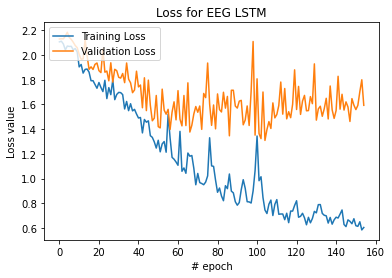

In [187]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss for EEG LSTM')
plt.ylabel('Loss value')
plt.xlabel('# epoch')
plt.legend(loc="upper left")
plt.show()